In [ ]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os


dataset_path = Path('data') / 'data.mat'
if not dataset_path.exists():
    alt = Path.cwd().parent / 'data' / 'data.mat'
    if alt.exists():
        dataset_path = alt
    else:
        raise FileNotFoundError(f"data.mat not found under {Path.cwd()} or its parent")

notebook_path = os.getcwd() 
print (f"Current notebook path: {notebook_path}")
project_root = os.path.dirname(notebook_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print (f"Added {project_root} to sys.path")

mat_data = loadmat(dataset_path)
print(mat_data.keys())

In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
# Pro plnou CUDA reprodukovatelnost (volitelné, ale doporučené)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
# --------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [3]:
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 

# --- KROK 1: Extrakce 1D os z 2D mřížek ---
# Získáme unikátní souřadnice pro osy X a Y.
# Pro osu X vezmeme první řádek z X matice.
# Pro osu Y vezmeme první sloupec z Y matice.
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Rozměry 1D osy X: {x_axis_unique.shape}")
print(f"Rozměry 1D osy Y: {y_axis_unique.shape}")
print(f"Rozměry 2D dat výšek Z: {souradniceZ_mapa.shape}")


# --- KROK 2: Vytvoření interpolačního objektu ---
# POZOR: Scipy očekává, že osy budou v pořadí (y, x), protože
# NumPy pole jsou indexována jako (řádek, sloupec), což odpovídá (y, x).
print("\nVytvářím interpolační funkci...")
terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),  # N-tice 1D os (nejprve Y, pak X)
    souradniceZ_mapa,
    bounds_error=False,  # NEVYHAZUJ CHYBU
    fill_value=np.nan
)
print("...interpolační funkce vytvořena.")

# --- KROK 3: Vytvoření finální, uživatelsky přívětivé funkce ---
def terMap(px, py):
    """
    Vypočítá nadmořskou výšku pro dané souřadnice (px, py)
    pomocí interpolace z mapy terénu.
    
    Funkce zvládne jak jednotlivé body, tak celé pole bodů.
    """
    # Spojíme vstupní body do formátu, kterému interpolátor rozumí:
    # pole o dvou sloupcích [y, x].
    points_to_query = np.column_stack((py, px))
    
    # Zavoláme interpolátor a vrátíme výsledek
    return terMap_interpolator(points_to_query)

Rozměry 1D osy X: (2500,)
Rozměry 1D osy Y: (2500,)
Rozměry 2D dat výšek Z: (2500, 2500)

Vytvářím interpolační funkci...
...interpolační funkce vytvořena.


# 4D model


In [4]:
import torch
from math import pi
from Systems import DynamicSystemTAN

state_dim = 4
obs_dim = 3
dT = 1
q = 1

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[3.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
initial_velocity = torch.from_numpy(initial_velocity_np)

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()
print(x_0)

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])

def h_nl_robust(x: torch.Tensor) -> torch.Tensor:
    # ... (implementace s clampingem, jak jsme si ukázali dříve) ...
    # Získání hranic mapy
    min_x, max_x = x_axis_unique.min(), x_axis_unique.max()
    min_y, max_y = y_axis_unique.min(), y_axis_unique.max()

    # Oříznutí pozic POUZE pro dotaz do mapy
    px_safe = x[:, 0].clone().clamp(min_x, max_x)
    py_safe = x[:, 1].clone().clamp(min_y, max_y)
    vel_safe = 200.0 # ciste kvuli numericke explozi

    vyska_terenu_np = terMap(px_safe.detach().cpu().numpy(), py_safe.detach().cpu().numpy())
    vyska_terenu = torch.from_numpy(vyska_terenu_np).float().to(x.device)
    
    # Zbytek výpočtu s původními rychlostmi
    eps = 1e-12


    vx_w, vy_w = x[:, 2], x[:, 3]
    vx_w = x[:, 2].clamp(-vel_safe, vel_safe)
    vy_w = x[:, 3].clamp(-vel_safe, vel_safe)
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w
    vx_b = cos_psi * vx_w - sin_psi * vy_w
    vy_b = sin_psi * vx_w + cos_psi * vy_w
    
    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)
    
    # Pojistka pro případ, že by terMap přesto vrátila NaN
    if torch.isnan(result).any():
        print("Varování: NaN hodnoty v měření detekovány, nahrazuji nulami.")
        result[torch.isnan(result)] = 0

    return result
import torch.nn.functional as func

def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    batch_size = x.shape[0]

    # 1. Získání pozic
    px = x[:, 0]
    py = x[:, 1]

    # 2. Normalizace souřadnic na [-1, 1]
    # (px - x_min) / (x_max - x_min) -> [0, 1]
    # 2.0 * (...) - 1.0               -> [-1, 1]
    # POZOR: grid_sample očekává souřadnice v pořadí (x, y)
    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    # 3. Sestavení "sampling grid"
    # grid_sample chce tvar [B, H_out, W_out, 2]
    # Pro dotaz na jednotlivé body chceme [B, 1, 1, 2]
    # Pořadí v poslední dimenzi je (x_souřadnice, y_souřadnice)
    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    # 4. Interpolace (plně v PyTorchi)
    # mode='bilinear' je standardní interpolace
    # padding_mode='border' ořízne dotazy na hranice mapy (jako tvůj clamp)
    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1), # Rozšíříme mapu pro celou dávku
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border', # Ekvivalent 'clamp'
        align_corners=True     # Důležité pro správné mapování rohů
    )

    # Výstup je [B, 1, 1, 1], musíme ho zformovat na [B]
    vyska_terenu = vyska_terenu_batch.view(batch_size)

    # --- Zbytek tvé funkce (výpočet rychlostí) je v pořádku ---
    eps = 1e-12
    vx_w, vy_w = x[:, 2], x[:, 3]
    vel_safe = 100.0 # ciste kvuli numericke explozi
    vx_w = x[:, 2].clamp(-vel_safe, vel_safe)
    vy_w = x[:, 3].clamp(-vel_safe, vel_safe)
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    # Toto je aproximace, cos(psi)*vx - (-sin(psi))*vy?
    # A sin(psi)*vx + cos(psi)*vy?
    # Ověř si tu transformaci, ale je diferencovatelná.
    vx_b = cos_psi * vx_w - sin_psi * vy_w 
    vy_b = sin_psi * vx_w + cos_psi * vy_w

    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)

    return result

x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]
# --- Příprava mapových dat pro h() ---
terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0).to(device)
x_min, x_max = x_axis_unique.min(), x_axis_unique.max()
y_min, y_max = y_axis_unique.min(), y_axis_unique.max()

print(f"INFO: Mapový tenzor připraven: {terMap_tensor.shape}")
print(f"INFO: Hranice mapy: X=[{x_min}-{x_max}], Y=[{y_min}-{y_max}]")
# --- Vytvoření instance DynamicSystemTAN s diferencovatelnou h() ---
print("Vytvářím instanci DynamicSystemTAN...")

# Vytvoříme "wrapper" funkci, která má "zabudované" argumenty mapy
# a navenek přijímá pouze 'x'
h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min, 
    x_max=x_max, 
    y_min=y_min, 
    y_max=y_max
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_wrapper,  # <-- ZDE JE KLÍČOVÁ ZMĚNA
    x_axis_unique=x_axis_unique, # (Tyto už asi nebudou potřeba,
    y_axis_unique=y_axis_unique, #  ale nechme je tam pro teď)
    device=device
)

tensor([ 1.4875e+06,  6.3955e+06,  4.3225e+00, -4.1456e+01])
INFO: Mapový tenzor připraven: torch.Size([1, 1, 2500, 2500])
INFO: Hranice mapy: X=[1476611.4218400645-1489541.4747185395], Y=[6384032.632255394-6400441.338746874]
Vytvářím instanci DynamicSystemTAN...
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [1476611.42, 1489541.47]
  Y: [6384032.63, 6400441.34]


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from Systems import DynamicSystemTAN 
from copy import deepcopy 
import numpy as np
import random 
# Musíme importovat tvůj 'utils' modul, aby bylo možné volat 'utils.generate_data_for_map'
from utils import utils 

# --- Konfigurace (Podle článku) ---
TRAIN_SEQ_LEN = 100      # 'D' = 50
VALID_SEQ_LEN = 200     # Delší pro validaci
NUM_TRAIN_SETS = 100
TRAJ_PER_SET_TRAIN = 4
NUM_VALID_SETS = 20
TRAJ_PER_SET_VALID = 5
BATCH_SIZE = 256          # Můžeš zkusit zvýšit, pokud VRAM dovolí (autoři měli 256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

# --- Načtení GNSS (Předpokládáme, že existuje) ---
num_gnss_points = souradniceGNSS.shape[1]
print(f"Načteno {num_gnss_points} GNSS bodů pro výběr počátečních podmínek.")
original_system_model = system_model 
default_P0 = torch.diag(torch.tensor([25.0, 25.0, 0.5, 0.5], device=device)).float()

# --- Generování trénovacích dat (D=50) ---
print("Generuji trénovací data s náhodnými počátečními podmínkami z GNSS...")
all_x_train = []
all_y_train = []
for i in range(NUM_TRAIN_SETS):
    print(f"  Generuji trénovací sadu {i+1}/{NUM_TRAIN_SETS}...")

    # 1. Náhodně vyber startovní index t
    start_index = random.randint(0, num_gnss_points - 2)

    # 2. Vypočítej Ex0 z GNSS dat
    initial_pos_np = souradniceGNSS[:2, start_index]
    next_pos_np = souradniceGNSS[:2, start_index + 1]
    initial_vel_np = next_pos_np - initial_pos_np
    Ex0_sampled = torch.cat([
        torch.from_numpy(initial_pos_np),
        torch.from_numpy(initial_vel_np)
    ]).float().to(device)

    # 3. Vyber P0
    P0_current = default_P0

    # 4. Vytvoř dočasný model a generuj data
    temp_model = deepcopy(original_system_model)
    temp_model.Ex0 = Ex0_sampled
    temp_model.P0 = P0_current

    # (Výpis pro kontrolu)
    # print(f"    Startovní index: {start_index}, Ex0: {Ex0_sampled.cpu().numpy()}") 

    # Používáme tvou funkci 'generate_data_for_map', která řeší hranice mapy
    x_batch, y_batch = utils.generate_data_for_map(
        temp_model,
        num_trajectories=TRAJ_PER_SET_TRAIN,
        seq_len=TRAIN_SEQ_LEN
    )
    all_x_train.append(x_batch)
    all_y_train.append(y_batch)

x_train = torch.cat(all_x_train, dim=0)
y_train = torch.cat(all_y_train, dim=0)
print(f"Finální trénovací data: x={x_train.shape}, y={y_train.shape}")

# --- Generování validačních dat (D=200) ---
print("Generuji validační data s náhodnými počátečními podmínkami z GNSS...")
all_x_val = []
all_y_val = []
for i in range(NUM_VALID_SETS):
    print(f"  Generuji validační sadu {i+1}/{NUM_VALID_SETS}...")
    start_index = random.randint(0, num_gnss_points - 2)
    initial_pos_np = souradniceGNSS[:2, start_index]
    next_pos_np = souradniceGNSS[:2, start_index + 1]
    initial_vel_np = next_pos_np - initial_pos_np 
    Ex0_sampled = torch.cat([
        torch.from_numpy(initial_pos_np),
        torch.from_numpy(initial_vel_np)
    ]).float().to(device)
    P0_current = default_P0 

    temp_model = deepcopy(original_system_model)
    temp_model.Ex0 = Ex0_sampled
    temp_model.P0 = P0_current

    # (Výpis pro kontrolu)
    # print(f"    Startovní index: {start_index}, Ex0: {Ex0_sampled.cpu().numpy()}")

    x_batch, y_batch = utils.generate_data_for_map(
        temp_model,
        num_trajectories=TRAJ_PER_SET_VALID,
        seq_len=VALID_SEQ_LEN
    )
    all_x_val.append(x_batch)
    all_y_val.append(y_batch)

x_val = torch.cat(all_x_val, dim=0)
y_val = torch.cat(all_y_val, dim=0)
print(f"Finální validační data: x={x_val.shape}, y={y_val.shape}")

# <--- PŘIDÁNO ZDE: VÝPOČET NORMALIZAČNÍCH STATISTIK ---
print("\nPočítám normalizační statistiky (průměr a std) z trénovacích dat...")

# Získáme state_dim (což je 4) z modelu
state_dim = original_system_model.state_dim

# Zploštíme data, abychom získali průměr/std přes všechny časové kroky a trajektorie
# Tvar x_train je [N_traj, Seq_Len, State_Dim]
# Tvar x_train_flat bude [N_traj * Seq_Len, State_Dim]
x_train_flat = x_train.view(-1, state_dim)

# Vypočítáme průměr a std pro každou ze 4 komponent stavu
x_mean = x_train_flat.mean(dim=0).to(device)
x_std = x_train_flat.std(dim=0).to(device)

# Pojistka proti dělení nulou, pokud by nějaká komponenta byla náhodou konstantní
x_std[x_std == 0] = 1.0

print(f"  Vypočtený průměr (x_mean): {x_mean.cpu().numpy()}")
print(f"  Vypočtená odchylka (x_std): {x_std.cpu().numpy()}")
# <--- KONEC PŘIDANÉ ČÁSTI ---

# --- Vytvoření DataLoaderů ---
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nDataLoadery jsou připraveny pro trénink.")

Používané zařízení: cuda
Načteno 1276 GNSS bodů pro výběr počátečních podmínek.
Generuji trénovací data s náhodnými počátečními podmínkami z GNSS...
  Generuji trénovací sadu 1/100...
INFO: Generátor dat používá hranice X:[1476611.42-1489541.47], Y:[6384032.63-6400441.34]
Generuji 4 platných trajektorií (metoda zahození)...
  Úspěšně vygenerována trajektorie 1/4 (Pokusů: 1)
  Úspěšně vygenerována trajektorie 2/4 (Pokusů: 2)
  Úspěšně vygenerována trajektorie 3/4 (Pokusů: 3)
  Úspěšně vygenerována trajektorie 4/4 (Pokusů: 4)
------------------------------
Generování dat dokončeno.
Celkový počet pokusů: 4
Úspěšnost (platné trajektorie / pokusy): 100.00%
Celkový počet vygenerovaných trajektorií: torch.Size([4, 100, 4])
  Generuji trénovací sadu 2/100...
INFO: Generátor dat používá hranice X:[1476611.42-1489541.47], Y:[6384032.63-6400441.34]
Generuji 4 platných trajektorií (metoda zahození)...
  Úspěšně vygenerována trajektorie 1/4 (Pokusů: 1)
  Úspěšně vygenerována trajektorie 2/4 (Pokusů

In [6]:
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# from Systems import DynamicSystemTAN # Nebo jak se jmenuje tvůj model
# from copy import deepcopy # Pro vytvoření kopie modelu
# import numpy as np
# import random # Pro náhodný výběr indexu


# # --- Konfigurace (stejná jako předtím) ---
# TRAIN_SEQ_LEN = 50
# VALID_SEQ_LEN = 200
# NUM_TRAIN_SETS =400 # Kolik různých náhodných počátečních podmínek pro trénink
# NUM_VALID_SETS = 100 # Kolik různých náhodných počátečních podmínek pro validaci
# TRAJ_PER_SET_TRAIN = 2 # Kolik trajektorií na jednu počáteční podmínku
# TRAJ_PER_SET_VALID = 2 # Kolik trajektorií na jednu počáteční podmínku
# BATCH_SIZE = 8
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # --- Načti souradniceGNSS (předpokládá se, že už existuje) ---
# # souradniceGNSS = mat_data['souradniceGNSS'] # Pole tvaru [rozměr, čas]
# num_gnss_points = souradniceGNSS.shape[1]
# print(f"Načteno {num_gnss_points} GNSS bodů pro výběr počátečních podmínek.")

# # --- Zde definuj tvůj původní system_model ---
# # Předpokládám, že existuje proměnná 'system_model' s nějakými výchozími Ex0 a P0
# original_system_model = system_model # Uchovej si originál

# # --- Definuj varianty pro P0 (volitelné, můžeš použít jen jednu) ---
# default_P0 = torch.diag(torch.tensor([25.0, 25.0, 0.5, 0.5], device=device)).float()
# # Můžeš přidat další P0 varianty sem, pokud chceš větší variabilitu
# # P0_options = [
# #     torch.diag(torch.tensor([50.0, 50.0, 1.0, 1.0], device=device)).float(),
# #     torch.diag(torch.tensor([100.0, 100.0, 2.0, 2.0], device=device)).float(),
# #     torch.diag(torch.tensor([25.0, 25.0, 0.5, 0.5], device=device)).float()
# # ]


# # --- Generování trénovacích dat ---
# print("Generuji trénovací data s náhodnými počátečními podmínkami z GNSS...")
# all_x_train = []
# all_y_train = []
# for i in range(NUM_TRAIN_SETS):
#     print(f"  Generuji sadu {i+1}/{NUM_TRAIN_SETS}...")

#     # 1. Náhodně vyber startovní index t (musí být t+1 platný index)
#     start_index = random.randint(0, num_gnss_points - 2)

#     # 2. Vypočítej Ex0 z GNSS dat
#     initial_pos_np = souradniceGNSS[:2, start_index]
#     next_pos_np = souradniceGNSS[:2, start_index + 1]
#     # Výpočet rychlosti jako rozdíl pozic (předpokládá dT=1 mezi GNSS body, uprav pokud ne)
#     # Pokud dT pro GNSS není 1, děl rychlost tímto dT
#     initial_vel_np = next_pos_np - initial_pos_np
#     Ex0_sampled = torch.cat([
#         torch.from_numpy(initial_pos_np),
#         torch.from_numpy(initial_vel_np)
#     ]).float().to(device)

#     # 3. Vyber P0 (zde používáme defaultní, můžeš přidat random.choice(P0_options))
#     P0_current = default_P0

#     # 4. Vytvoř dočasný model a generuj data
#     temp_model = deepcopy(original_system_model)
#     temp_model.Ex0 = Ex0_sampled
#     temp_model.P0 = P0_current

#     print(f"    Startovní index: {start_index}, Ex0: {Ex0_sampled.cpu().numpy()}") # Výpis pro kontrolu

#     x_batch, y_batch = utils.generate_data_for_map(
#         temp_model,
#         num_trajectories=TRAJ_PER_SET_TRAIN,
#         seq_len=TRAIN_SEQ_LEN
#     )
#     all_x_train.append(x_batch)
#     all_y_train.append(y_batch)

# x_train = torch.cat(all_x_train, dim=0)
# y_train = torch.cat(all_y_train, dim=0)
# print(f"Finální trénovací data: x={x_train.shape}, y={y_train.shape}")

# # --- Generování validačních dat (analogicky) ---
# print("Generuji validační data s náhodnými počátečními podmínkami z GNSS...")
# all_x_val = []
# all_y_val = []
# for i in range(NUM_VALID_SETS):
#     print(f"  Generuji sadu {i+1}/{NUM_VALID_SETS}...")
#     start_index = random.randint(0, num_gnss_points - 2)
#     initial_pos_np = souradniceGNSS[:2, start_index]
#     next_pos_np = souradniceGNSS[:2, start_index + 1]
#     initial_vel_np = next_pos_np - initial_pos_np # Uprav dělení dT, pokud je potřeba
#     Ex0_sampled = torch.cat([
#         torch.from_numpy(initial_pos_np),
#         torch.from_numpy(initial_vel_np)
#     ]).float().to(device)
#     P0_current = default_P0 # Nebo random.choice(P0_options)

#     temp_model = deepcopy(original_system_model)
#     temp_model.Ex0 = Ex0_sampled
#     temp_model.P0 = P0_current

#     print(f"    Startovní index: {start_index}, Ex0: {Ex0_sampled.cpu().numpy()}")

#     x_batch, y_batch = utils.generate_data_for_map(
#         temp_model,
#         num_trajectories=TRAJ_PER_SET_VALID,
#         seq_len=VALID_SEQ_LEN
#     )
#     all_x_val.append(x_batch)
#     all_y_val.append(y_batch)

# x_val = torch.cat(all_x_val, dim=0)
# y_val = torch.cat(all_y_val, dim=0)
# print(f"Finální validační data: x={x_val.shape}, y={y_val.shape}")

# # --- Vytvoření DataLoaderů ---
# train_dataset = TensorDataset(x_train, y_train)
# val_dataset = TensorDataset(x_val, y_val)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# print("\nDataLoadery jsou připraveny pro trénink.")

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
from copy import deepcopy
from state_NN_models import StateKalmanNet_v2 
from utils import trainer 
# -----------------------------

# Nastavení seedu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

state_knet2 = StateKalmanNet_v2(
    system_model=original_system_model, 
    device=device,
).to(device)

# --- Spuštění tréninku ---
print("Spouštím trénink...")
trained_model = trainer.train_state_KalmanNet_sliding_window(
    model=state_knet2,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=200,
    lr=1e-3, # Vyšší LR, jak radil autor
    clip_grad=1.0,
    early_stopping_patience=20,
    tbptt_k=2,
    tbptt_w=8, # (2, 4, 50) nebo (2, 8, 50)
    optimizer_=torch.optim.AdamW,
    weight_decay_=1e-3,

)

Inicializuji váhy pro StateKalmanNet_v2 (Arch 1)...
Spouštím trénink...
INFO: Detekováno z atributu modelu, že vrací kovarianci: False
INFO: Spouštím trénink s TBPTT(k=2, w=8)
Nové nejlepší model uloženo! Epoch [1/200], Train Loss: 765290424.293250, Val Loss: 467773292544.000000
Nové nejlepší model uloženo! Epoch [2/200], Train Loss: 23019863838.326923, Val Loss: 313749667840.000000
Nové nejlepší model uloženo! Epoch [3/200], Train Loss: 11681354535.884617, Val Loss: 549873024.000000
Epoch [5/200], Train Loss: 13361704159.730770, Val Loss: 624418560.000000
Nové nejlepší model uloženo! Epoch [6/200], Train Loss: 245378314.043870, Val Loss: 224272864.000000
Epoch [10/200], Train Loss: 95947962.338942, Val Loss: 288632544.000000
Nové nejlepší model uloženo! Epoch [11/200], Train Loss: 35072909.641827, Val Loss: 77620744.000000
Nové nejlepší model uloženo! Epoch [12/200], Train Loss: 5387188.727013, Val Loss: 57892124.000000
Nové nejlepší model uloženo! Epoch [14/200], Train Loss: 22284750

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import TensorDataset, DataLoader
# import numpy as np
# import os
# import random
# from copy import deepcopy
# from state_NN_models import KalmanNet_Arch2 
# from utils import trainer 
# # -----------------------------

# # Nastavení seedu
# torch.manual_seed(42)
# np.random.seed(42)
# random.seed(42)

# # IMPLEMENTACE BEZ TANH A BEZ OMEZENÍ STAVŮ
# # Vytvoření modelu (KalmanNet_Arch2) s hyperparametry autorů
# state_knet2 = KalmanNet_Arch2(
#     system_model, 
#     device=device,
#     in_mult_KNet=5,     # Podle kódu autorů 
#     out_mult_KNet=40    # Podle kódu autorů 
# ).to(device)

# print(state_knet2)

# trainer.train_state_KalmanNet_sliding_window(
#     model=state_knet2, 
#     train_loader=train_loader, 
#     val_loader=val_loader, 
#     device=device, 
#     epochs=200,                  # Podle kódu autorů 
#     lr=1e-4,                    # Podle kódu autorů (0.001) 
#     early_stopping_patience=30, # Můžeme nechat 
#     clip_grad=1.0,              # Podle kódu autorů (gradient_clip_val=1) 
#     tbptt_k=2,                  # Podle kódu autorů (detach_step=2) 
#     tbptt_w=8                   # Podle kódu autorů (slide_win_size=4 nebo 8) 
# )

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import TensorDataset, DataLoader
# import numpy as np
# import os
# import random
# from copy import deepcopy
# from state_NN_models import KalmanNet_Arch2_tanh 
# from utils import trainer 
# # -----------------------------

# # Nastavení seedu
# torch.manual_seed(42)
# np.random.seed(42)
# random.seed(42)

# # IMPLEMENTACE S TANH PRO OMEZENÍ K A CLAMP STAVŮ
# # Vytvoření modelu (KalmanNet_Arch2_tanh) s hyperparametry autorů
# state_knet2 = KalmanNet_Arch2_tanh(
#     system_model, 
#     device=device,
#     in_mult_KNet=5,     # Podle kódu autorů 
#     out_mult_KNet=40    # Podle kódu autorů 
# ).to(device)

# print(state_knet2)

# trainer.train_state_KalmanNet_sliding_window_statistiky(
#     model=state_knet2, 
#     train_loader=train_loader, 
#     val_loader=val_loader, 
#     device=device, 
#     x_mean=x_mean,           # PŘIDÁNO: průměr pro normalizaci
#     x_std=x_std,             # PŘIDÁNO: std pro normalizaci
#     epochs=200,                  # Podle kódu autorů 
#     lr=1e-4,                    # Podle kódu autorů (0.001) 
#     early_stopping_patience=30, # Můžeme nechat 
#     clip_grad=1.0,              # Podle kódu autorů (gradient_clip_val=1) 
#     tbptt_k=2,                  # Podle kódu autorů (detach_step=2) 
#     tbptt_w=8                   # Podle kódu autorů (slide_win_size=4 nebo 8) 
# )

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import TensorDataset, DataLoader
# import numpy as np
# import os
# import random
# from copy import deepcopy
# from state_NN_models import KalmanNet_Arch2_tanh 
# from utils import trainer 
# # -----------------------------

# # Nastavení seedu
# torch.manual_seed(42)
# np.random.seed(42)
# random.seed(42)

# # IMPLEMENTACE S TANH PRO OMEZENÍ K A CLAMP STAVŮ
# # Vytvoření modelu (KalmanNet_Arch2_tanh) s hyperparametry autorů
# state_knet2 = KalmanNet_Arch2_tanh(
#     system_model, 
#     device=device,
#     in_mult_KNet=5,     # Podle kódu autorů 
#     out_mult_KNet=40    # Podle kódu autorů 
# ).to(device)

# print(state_knet2)

# trainer.train_state_KalmanNet_sliding_window_weighted_mse(
#     model=state_knet2, 
#     train_loader=train_loader, 
#     val_loader=val_loader, 
#     device=device,             # PŘIDÁNO: std pro normalizaci
#     epochs=200,                  # Podle kódu autorů 
#     lr=1e-3,                    # Podle kódu autorů (0.001) 
#     early_stopping_patience=30, # Můžeme nechat 
#     clip_grad=1.0,              # Podle kódu autorů (gradient_clip_val=1) 
#     tbptt_k=2,                  # Podle kódu autorů (detach_step=2) 
#     tbptt_w=8,                   # Podle kódu autorů (slide_win_size=4 nebo 8) 
#     pos_weight=1.0,
#     vel_weight=1000.0
# )

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import TensorDataset, DataLoader
# import numpy as np
# import os
# import random
# import csv
# from datetime import datetime
# import pandas as pd
# from copy import deepcopy
# from state_NN_models import StateKalmanNet_v2_4D_tan

# # Nastavení seedu pro reprodukovatelnost tohoto běhu
# torch.manual_seed(42)
# np.random.seed(42)
# random.seed(42)
# state_knet = StateKalmanNet_v2_4D_tan(system_model=system_model, device=device, hidden_size_multiplier=14, output_layer_multiplier=4, num_gru_layers=2).to(device)
# print(state_knet)
# trainer.train_state_KalmanNet(
#     model=state_knet, 
#     train_loader=train_loader, 
#     val_loader=val_loader, 
#     device=device, 
#     epochs=200, 
#     lr=1e-5,
#     early_stopping_patience=20,
#     clip_grad=1.0
# )

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader



# ==============================================================================
# 1. KONFIGURACE TESTU
# ==============================================================================
TEST_SEQ_LEN = 600 # Změňte zpět na 100 nebo kolik potřebujete
NUM_TEST_TRAJ = 10
J_SAMPLES_TEST = 25

# ==============================================================================
# 2. PŘÍPRAVA DAT (OPRAVENO)
# ==============================================================================
print(f"\nGeneruji {NUM_TEST_TRAJ} testovacích trajektorií o délce {TEST_SEQ_LEN}...")

# Nyní předáme oříznutou sekvenci 'u', takže i 'x' a 'y' budou mít správnou délku.
x_test, y_test = utils.generate_data_for_map(
    system_model, 
    num_trajectories=NUM_TEST_TRAJ,
    seq_len=TEST_SEQ_LEN
)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Generování dat dokončeno.")

print("y shape:", y_test.shape) # Mělo by být [1, 20, 1]
print("x shape:", x_test.shape) # Mělo by být [1, 20, 3]



# ==============================================================================
# 3. INICIALIZACE FILTRŮ
# ==============================================================================
ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
pf_sir_ideal = Filters.ParticleFilter(system_model, num_particles=10000)

# ==============================================================================
# 4. VYHODNOCOVACÍ SMYČKA (OPRAVENO)
# ==============================================================================
all_x_true_cpu = []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_pf_sir_ideal_cpu, all_P_hat_pf_sir_ideal_cpu = [], []
all_x_hat_classic_knet_cpu = []
all_x_hat_bkn_cpu, all_P_hat_bkn_cpu = [], []
all_x_hat_knet_F3_cpu = []
all_x_hat_classic_knet2_cpu = []

all_knet_diagnostics_cpu = []
print(f"\nVyhodnocuji modely na {NUM_TEST_TRAJ} testovacích trajektoriích...")

# state_knet.eval()
state_knet2.eval()
# state_knet_F3.eval()


with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        initial_state = x_true_seq_gpu[0, :].unsqueeze(0)


        # # --- A. Bayesian KalmanNet (Trajectory-wise) ---
        # ensemble_trajectories = []
        # for j in range(J_SAMPLES_TEST):
        #     state_bkn_knet.reset(batch_size=1, initial_state=initial_state)
        #     current_x_hats = []
        #     for t in range(1, TEST_SEQ_LEN):
        #         x_filtered_t, _ = state_bkn_knet.step(y_test_seq_gpu[t, :].unsqueeze(0))
        #         current_x_hats.append(x_filtered_t)
        #     ensemble_trajectories.append(torch.cat(current_x_hats, dim=0))
        # ensemble = torch.stack(ensemble_trajectories, dim=0)
        # predictions_bkn = ensemble.mean(dim=0)
        # diff = ensemble - predictions_bkn.unsqueeze(0)
        # covariances_bkn = (diff.unsqueeze(-1) @ diff.unsqueeze(-2)).mean(dim=0)
        # full_x_hat_bkn = torch.cat([initial_state, predictions_bkn], dim=0)
        # full_P_hat_bkn = torch.cat([system_model.P0.unsqueeze(0), covariances_bkn], dim=0)


        # --- B. Klasický StateKalmanNet (pouze MSE) ---
        # state_knet.reset(batch_size=1, initial_state=initial_state)
        # classic_knet_preds = []
        # for t in range(1, TEST_SEQ_LEN):
        #     x_filtered_t = state_knet.step(y_test_seq_gpu[t, :].unsqueeze(0))
        #     classic_knet_preds.append(x_filtered_t)
        # full_x_hat_classic_knet = torch.cat([initial_state, torch.cat(classic_knet_preds, dim=0)], dim=0)
        # diagnostics = state_knet.get_diagnostics()
        # all_knet_diagnostics_cpu.append(diagnostics)

        state_knet2.reset(batch_size=1, initial_state=initial_state)
        classic_knet2_preds = []
        for t in range(1, TEST_SEQ_LEN):
            x_filtered_t = state_knet2.step(y_test_seq_gpu[t, :].unsqueeze(0))
            classic_knet2_preds.append(x_filtered_t)
        full_x_hat_classic_knet2 = torch.cat([initial_state, torch.cat(classic_knet2_preds, dim=0)], dim=0)


        ukf_i_res = ukf_ideal.process_sequence(
            y_seq=y_test_seq_gpu,
            Ex0=system_model.Ex0, 
            P0=system_model.P0
        )
        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']

        pf_sir_i_res = pf_sir_ideal.process_sequence(y_test_seq_gpu, Ex0=system_model.Ex0,P0=system_model.P0)
        full_x_hat_pf_sir_i = pf_sir_i_res['x_filtered']
        full_P_hat_pf_sir_i = pf_sir_i_res['P_filtered']
        full_particles_history_pf_sir_i = pf_sir_i_res['particles_history']
        print(f"PF-SIR (ideální model) dokončen pro trajektorii {i + 1}/{NUM_TEST_TRAJ}.")

        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        # all_x_hat_knet_F3_cpu.append(full_x_hat_classic_knet_F3.cpu())
        # all_x_hat_bkn_cpu.append(full_x_hat_bkn.cpu()); all_P_hat_bkn_cpu.append(full_P_hat_bkn.cpu())
        all_x_hat_classic_knet2_cpu.append(full_x_hat_classic_knet2.cpu())
        # all_x_hat_classic_knet_cpu.append(full_x_hat_classic_knet.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())
        all_x_hat_pf_sir_ideal_cpu.append(full_x_hat_pf_sir_i.cpu()); all_P_hat_pf_sir_ideal_cpu.append(full_P_hat_pf_sir_i.cpu())
        print(f"Dokončena trajektorie {i + 1}/{NUM_TEST_TRAJ}...")

# ==============================================================================
# 5. FINÁLNÍ VÝPOČET A VÝPIS METRIK
# ==============================================================================
# Seznamy pro sběr metrik
mse_bkn, anees_bkn = [], []; mse_ukf_ideal, anees_ukf_ideal = [], []
# mse_classic_knet = []

mse_pf_sir_ideal, anees_pf_sir_ideal = [], []
mse_classic_knet2 = []
# mse_knet_F3 = []

print("\nPočítám finální metriky pro jednotlivé trajektorie...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        x_true = all_x_true_cpu[i]
        def get_metrics(x_hat_full, P_hat_full):
            if x_hat_full.shape[0] != x_true.shape[0] or P_hat_full.shape[0] != x_true.shape[0]:
                 raise ValueError(f"Nesoulad délek! x_true: {x_true.shape[0]}, x_hat: {x_hat_full.shape[0]}, P_hat: {P_hat_full.shape[0]}")

            # Porovnáváme od kroku t=1
            mse = F.mse_loss(x_hat_full[1:], x_true[1:]).item()
            # ANEES se také typicky počítá od t=1 (ignoruje počáteční nejistotu P0)
            anees = utils.calculate_anees_vectorized(
                x_true[1:].unsqueeze(0),
                x_hat_full[1:].unsqueeze(0),
                P_hat_full[1:].unsqueeze(0)
            )
            return mse, anees

        # Výpočty pro všechny modely
        # mse, anees = get_metrics(all_x_hat_bkn_cpu[i], all_P_hat_bkn_cpu[i]); mse_bkn.append(mse); anees_bkn.append(anees)
        # mse = F.mse_loss(all_x_hat_knet_F3_cpu[i][1:], x_true[1:]).item(); mse_knet_F3.append(mse)
        mse = F.mse_loss(all_x_hat_classic_knet2_cpu[i][1:], x_true[1:]).item(); mse_classic_knet2.append(mse)
        # mse = F.mse_loss(all_x_hat_classic_knet_cpu[i][1:], x_true[1:]).item(); mse_classic_knet.append(mse)
        mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[i], all_P_hat_ukf_ideal_cpu[i]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_pf_sir_ideal_cpu[i], all_P_hat_pf_sir_ideal_cpu[i]); mse_pf_sir_ideal.append(mse); anees_pf_sir_ideal.append(anees)
        print("\n" + "="*80)
        print(f"trajektorie: {i + 1}/{NUM_TEST_TRAJ}")
        print("="*80)
        print("-" * 80)
        # print(f"{'Bayesian KNet (BKN)':<35} | {(mse_bkn[i]):<20.4f} | {(anees_bkn[i]):<20.4f}")
        # print(f"{'KNet F3 (pouze MSE)':<35} | {(mse_knet_F3[i]):<20.4f} | {'N/A':<20}")
        print(f"{'KNet2 (pouze MSE)':<35} | {(mse_classic_knet2[i]):<20.4f} | {'N/A':<20}")
        # print(f"{'KNet (pouze MSE)':<35} | {(mse_classic_knet[i]):<20.4f} | {'N/A':<20}")
        print(f"{'UKF (Ideální model)':<35} | {(mse_ukf_ideal[i]):<20.4f} | {(anees_ukf_ideal[i]):<20.4f}")
        print(f"{'PF-SIR (Ideální model)':<35} | {(mse_pf_sir_ideal[i]):<20.4f} | {(anees_pf_sir_ideal[i]):<20.4f}")
        print("="*80)
      
def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])
state_dim_for_nees = all_x_true_cpu[0].shape[1]

# --- Finální výpis tabulky ---
print("\n" + "="*80)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*80)
print(f"{'Model':<35} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 80)
print("-" * 80)
print(f"{'--- Model-Based Filters ---':<35} | {'':<20} | {'':<20}")
# print(f"{'Bayesian KNet (BKN)':<35} | {avg(mse_bkn):<20.4f} | {avg(anees_bkn):<20.4f}")
# print(f"{'KNet (pouze MSE)':<35} | {avg(mse_classic_knet):<20.4f} | {'N/A':<20}")
print(f"{'KNet2 (pouze MSE)':<35} | {avg(mse_classic_knet2):<20.4f} | {'N/A':<20}")
# print(f"{'KNet F3 (pouze MSE)':<35} | {avg(mse_knet_F3):<20.4f} | {'N/A':<20}")
print("-" * 80)
print(f"{'--- Benchmarks ---':<35} | {'':<20} | {'':<20}")
print(f"{'UKF (Ideální model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
print(f"{'PF-SIR (Ideální model)':<35} | {avg(mse_pf_sir_ideal):<20.4f} | {avg(anees_pf_sir_ideal):<20.4f}")
print("="*80)


Generuji 10 testovacích trajektorií o délce 600...
INFO: Generátor dat používá hranice X:[1476611.42-1489541.47], Y:[6384032.63-6400441.34]
Generuji 10 platných trajektorií (metoda zahození)...
  Úspěšně vygenerována trajektorie 1/10 (Pokusů: 19)
  Úspěšně vygenerována trajektorie 2/10 (Pokusů: 29)
  Úspěšně vygenerována trajektorie 3/10 (Pokusů: 36)
  Úspěšně vygenerována trajektorie 4/10 (Pokusů: 39)
  Úspěšně vygenerována trajektorie 5/10 (Pokusů: 80)
  Úspěšně vygenerována trajektorie 6/10 (Pokusů: 82)
  Úspěšně vygenerována trajektorie 7/10 (Pokusů: 98)
  Úspěšně vygenerována trajektorie 8/10 (Pokusů: 117)
  Úspěšně vygenerována trajektorie 9/10 (Pokusů: 218)
  Úspěšně vygenerována trajektorie 10/10 (Pokusů: 256)
------------------------------
Generování dat dokončeno.
Celkový počet pokusů: 256
Úspěšnost (platné trajektorie / pokusy): 3.91%
Celkový počet vygenerovaných trajektorií: torch.Size([10, 600, 4])
Generování dat dokončeno.
y shape: torch.Size([10, 600, 3])
x shape: torch

Varování: 'all_knet_diagnostics_cpu' nenalezeno nebo je prázdné. Diagnostické grafy (K, h, inovace) nebudou vykresleny.
Vykresluji grafy...
INFO: Přidávám hranice X (1476611.42, 1489541.47) do grafu Pozice X.
INFO: Přidávám hranice Y (6384032.63, 6400441.34) do grafu Pozice Y.


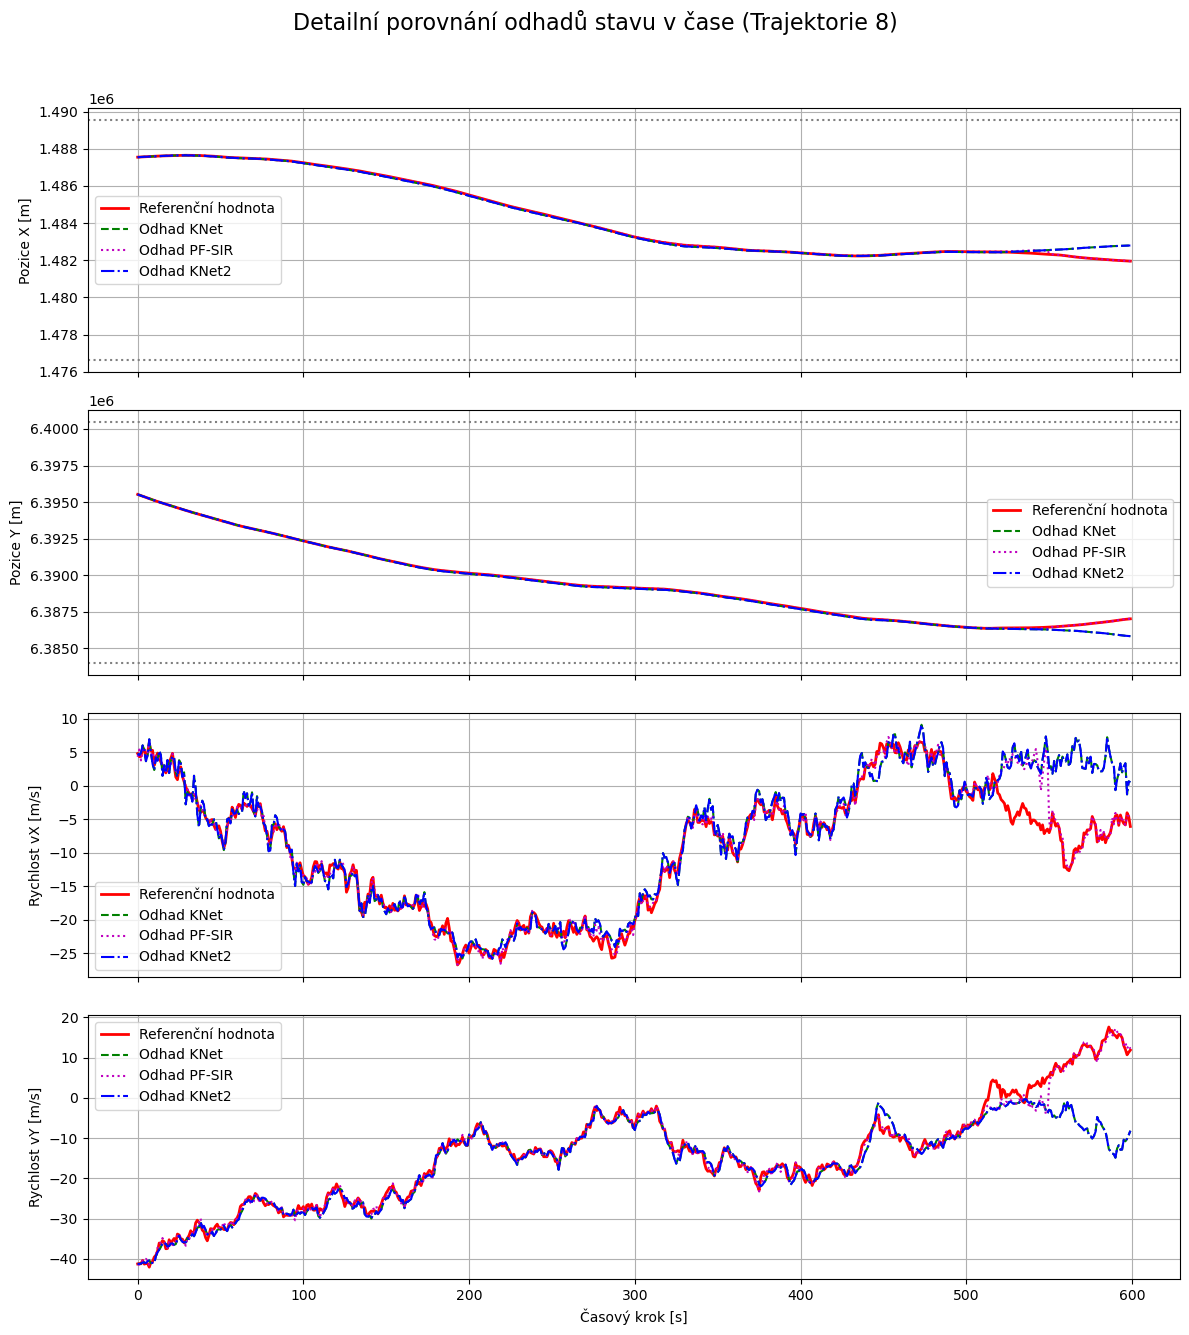

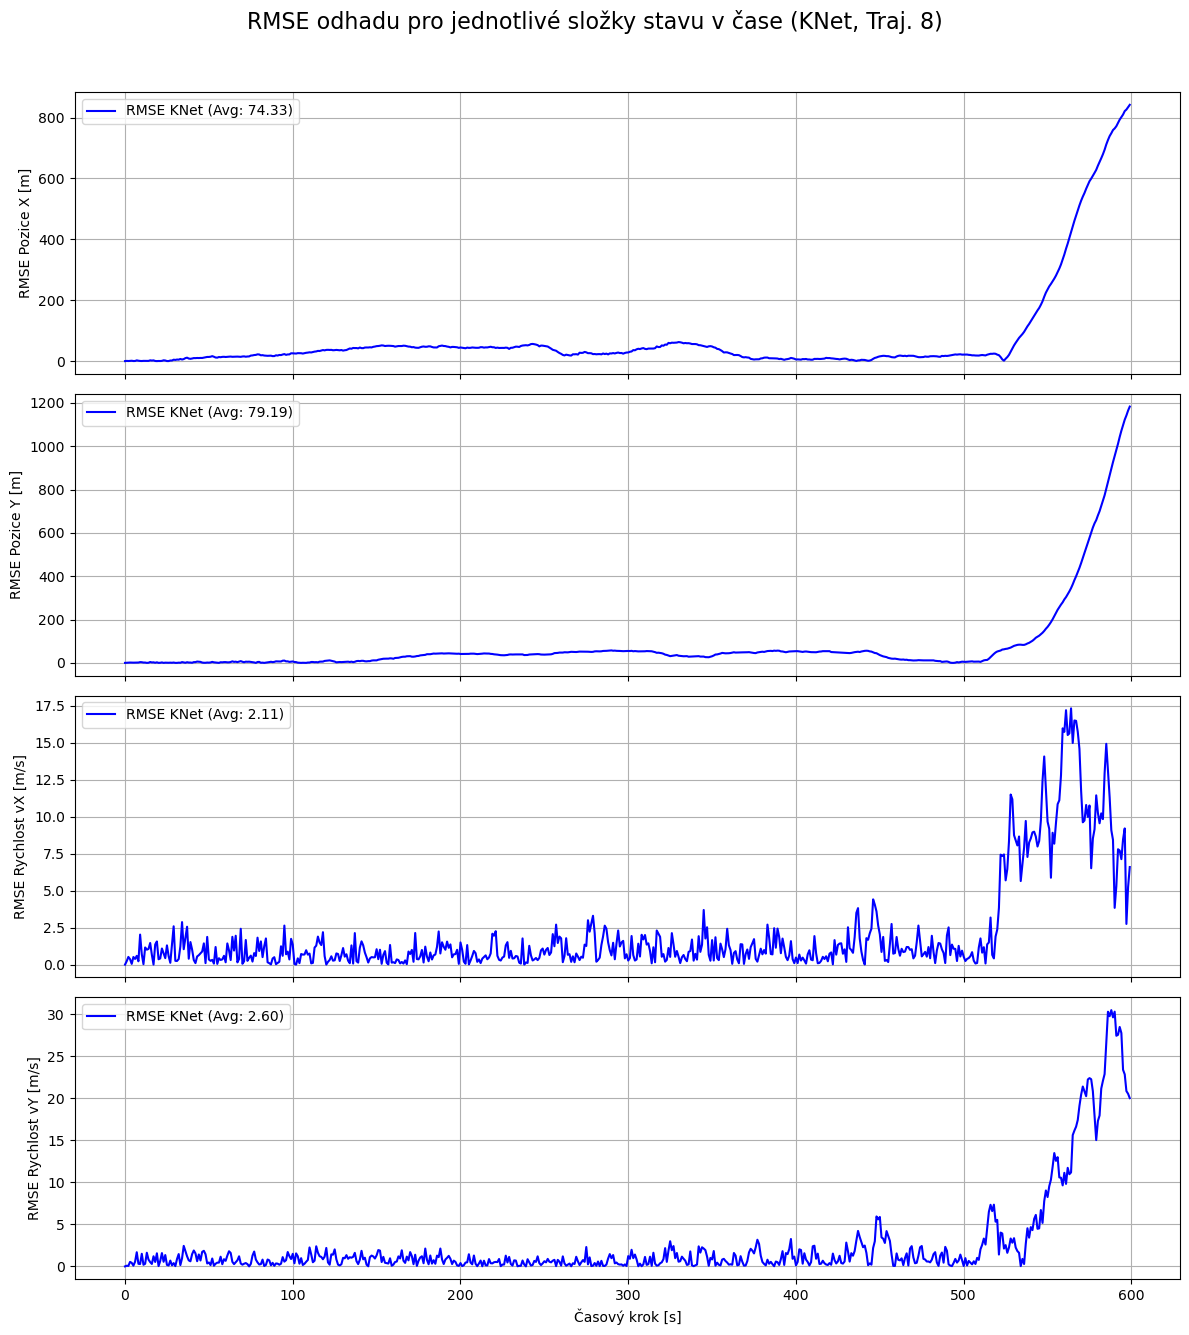

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch # Přidáno pro výpočet chyby a práci s tenzory

# <<< ZDE PŘEDPOKLÁDÁME EXISTENCI NÁSLEDUJÍCÍCH PROMĚNNÝCH >>>
# NUM_TEST_TRAJ = ... # Počet testovacích trajektorií
# all_x_true_cpu = [...] # Seznam pravdivých stavů
# all_x_hat_classic_knet_cpu = [...] # Seznam odhadů KNet
# all_x_hat_pf_sir_ideal_cpu = [...] # Seznam odhadů PF-SIR
# all_knet_diagnostics_cpu = [...] # <-- PŘEDPOKLAD: Seznam slovníků z vyhodnocení
# <<< KONEC PŘEDPOKLADŮ >>>

map_bounds = {
    'x_min': 1476611.42,
    'x_max': 1489541.47,
    'y_min': 6384032.63,
    'y_max': 6400441.34
}

# Zvolíme trajektorii pro vykreslení
index = 7  # Vykreslíme poslední trajektorii
if index < 0: index = 0

# ==============================================================================
# 1. PŘÍPRAVA DAT (stejná jako předtím + NOVÁ DIAGNOSTIKA)
# ==============================================================================

# --- Získání diagnostického slovníku pro daný 'index' ---
try:
    knet_diagnostics = all_knet_diagnostics_cpu[index]
    plot_diagnostics = True
except (NameError, IndexError):
    print("Varování: 'all_knet_diagnostics_cpu' nenalezeno nebo je prázdné. Diagnostické grafy (K, h, inovace) nebudou vykresleny.")
    plot_diagnostics = False
    plot_gains = False # Vypneme i graf zisku K

# --- Příprava dat trajektorií ---
x_true_plot = all_x_true_cpu[index].numpy()
x_true_tensor = all_x_true_cpu[index]
# x_knet_tensor = all_x_hat_classic_knet_cpu[index]
x_pf_tensor = all_x_hat_pf_sir_ideal_cpu[index]
x_knet2_tensor = all_x_hat_classic_knet2_cpu[index]
x_knet_tensor = x_knet2_tensor
# --- Výpočet RMSE ---
squared_error = (x_knet_tensor - x_true_tensor)**2
rmse_per_step = torch.sqrt(squared_error).numpy()

num_steps = x_true_plot.shape[0]
time_axis = np.arange(num_steps) # Časová osa od 0 do T-1
gain_time_axis = np.arange(1, num_steps) # Časová osa od 1 do T-1

# --- Příprava dat pro diagnostiku (pokud existují) ---
if plot_diagnostics:
    # --- Kalmanův zisk (K_t) ---
    try:
        kalman_gains_history = knet_diagnostics['K_history']
        # K[0, :, 0] znamená [batch_index, vsechny_stavy, prvni_prvek_mereni (vyska)]
        gains_col0_cpu = [K[0, :, 0].cpu().numpy() for K in kalman_gains_history] 
        gains_col0_np = np.array(gains_col0_cpu) # Převede seznam polí na 2D pole [čas (T-1), prvek (4)]
        plot_gains = True
        
        if gains_col0_np.shape[0] != len(gain_time_axis):
            print(f"Varování: Délka historie zisku ({gains_col0_np.shape[0]}) neodpovídá časové ose ({len(gain_time_axis)}). Graf zisku K nebude vykreslen.")
            plot_gains = False
            
    except Exception as e:
        print(f"Nastala chyba při zpracování Kalmanova zisku: {e}. Grafy K nebudou vykresleny.")
        plot_gains = False

    # --- Skrytý stav (h_t) ---
    try:
        h_history = knet_diagnostics['h_history']
        # h_history má T prvků (h_0 až h_T-1), h_t má tvar [num_layers, batch, hidden_dim]
        # Spočítáme L2 normu pro každý krok
        h_norms = [torch.norm(h.squeeze(1)).item() for h in h_history] # Squeeze pro odstranění 'batch' dim
        plot_h_norm = True
        
        if len(h_norms) != len(time_axis):
            print(f"Varování: Délka historie stavu h ({len(h_norms)}) neodpovídá časové ose ({len(time_axis)}). Graf h nebude vykreslen.")
            plot_h_norm = False
            
    except Exception as e:
        print(f"Nastala chyba při zpracování skrytého stavu h: {e}. Graf h nebude vykreslen.")
        plot_h_norm = False

    # --- Inovace (Delta y_t) ---
    try:
        innovation_history = knet_diagnostics['innovation_history']
        # innovation_history má T-1 prvků (pro t=1 až T-1), inovace má tvar [batch, obs_dim]
        innov_norms = [torch.norm(innov.squeeze(0)).item() for innov in innovation_history] # Squeeze pro odstranění 'batch' dim
        plot_innov_norm = True
        
        if len(innov_norms) != len(gain_time_axis):
            print(f"Varování: Délka historie inovace ({len(innov_norms)}) neodpovídá časové ose ({len(gain_time_axis)}). Graf inovace nebude vykreslen.")
            plot_innov_norm = False
            
    except Exception as e:
        print(f"Nastala chyba při zpracování inovace: {e}. Graf inovace nebude vykreslen.")
        plot_innov_norm = False
        

# --- Popisky grafů (Labels) ---
state_labels = [
    'Pozice X [m]',
    'Pozice Y [m]',
    'Rychlost vX [m/s]',
    'Rychlost vY [m/s]'
]
error_labels = [
    'RMSE Pozice X [m]',
    'RMSE Pozice Y [m]',
    'RMSE Rychlost vX [m/s]',
    'RMSE Rychlost vY [m/s]'
]
gain_labels = [
    'K[0,0] (Výška -> Pozice X)',
    'K[1,0] (Výška -> Pozice Y)',
    'K[2,0] (Výška -> Rychlost vX)',
    'K[3,0] (Výška -> Rychlost vY)'
]
diagnostic_labels = {
    'h_norm': 'L2 Norma skrytého stavu $h_t$',
    'innov_norm': 'L2 Norma inovace $\Delta y_t$'
}

# ==============================================================================
# 2. VYTVOŘENÍ GRAFŮ
# ==============================================================================
print("Vykresluji grafy...")

# --- Graf 1: Trajektorie ---
fig1, axes1 = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
fig1.suptitle(f'Detailní porovnání odhadů stavu v čase (Trajektorie {index+1})', fontsize=16)

# --- Graf 2: RMSE KNet ---
fig2, axes2 = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
fig2.suptitle(f'RMSE odhadu pro jednotlivé složky stavu v čase (KNet, Traj. {index+1})', fontsize=16)

# --- Graf 3: Kalmanův zisk KNet ---
if plot_gains:
    fig3, axes3 = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
    fig3.suptitle(f'Vývoj prvků 1. sloupce Kalmanova zisku KNet v čase (Traj. {index+1})', fontsize=16)

# --- Graf 4: Diagnostika (h_t a Inovace) ---
if plot_diagnostics and plot_h_norm and plot_innov_norm:
    fig4, axes4 = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig4.suptitle(f'Diagnostika vnitřních stavů KNet v čase (Traj. {index+1})', fontsize=16)
else:
    plot_h_norm = False
    plot_innov_norm = False


# --- Smyčka přes všechny 4 složky stavu (pro fig1, fig2, fig3) ---
for i in range(4):
    # --- Graf 1: Trajektorie ---
    ax1 = axes1[i]
    ax1.plot(time_axis, x_true_plot[:, i], 'r-', linewidth=2.0, label='Referenční hodnota')
    ax1.plot(time_axis, x_knet_tensor[:, i].numpy(), 'g--', linewidth=1.5, label='Odhad KNet')
    ax1.plot(time_axis, x_pf_tensor[:, i].numpy(), 'm:', linewidth=1.5, label='Odhad PF-SIR')
    ax1.plot(time_axis, x_knet2_tensor[:, i].numpy(), 'b-.', linewidth=1.5, label='Odhad KNet2')
    ax1.set_ylabel(state_labels[i])
    ax1.grid(True)
    ax1.legend()

    if i == 0: # Graf pro Pozici X
        ax1.axhline(map_bounds['x_min'], color='grey', linestyle=':', linewidth=1.5, label='Hranice mapy X')
        ax1.axhline(map_bounds['x_max'], color='grey', linestyle=':', linewidth=1.5)
        print(f"INFO: Přidávám hranice X ({map_bounds['x_min']:.2f}, {map_bounds['x_max']:.2f}) do grafu Pozice X.")
    elif i == 1: # Graf pro Pozici Y
        ax1.axhline(map_bounds['y_min'], color='grey', linestyle=':', linewidth=1.5, label='Hranice mapy Y')
        ax1.axhline(map_bounds['y_max'], color='grey', linestyle=':', linewidth=1.5)
        print(f"INFO: Přidávám hranice Y ({map_bounds['y_min']:.2f}, {map_bounds['y_max']:.2f}) do grafu Pozice Y.")
    
    # --- Graf 2: Chyba (RMSE) ---
    ax2 = axes2[i]
    ax2.plot(time_axis, rmse_per_step[:, i], 'b-', linewidth=1.5, label=f'RMSE KNet (Avg: {np.mean(rmse_per_step[1:, i]):.2f})')
    ax2.set_ylabel(error_labels[i])
    ax2.grid(True)
    ax2.legend()

    # --- Graf 3: Kalmanův zisk (pokud jsou data k dispozici) ---
    if plot_gains:
         ax3 = axes3[i]
         ax3.plot(gain_time_axis, gains_col0_np[:, i], 'k-', linewidth=1.5, label=f'{gain_labels[i]} (Avg: {np.mean(gains_col0_np[:, i]):.4f})')
         ax3.set_ylabel(gain_labels[i])
         ax3.grid(True)
         ax3.legend()

# --- Vykreslení Grafu 4 (Diagnostika) ---
if plot_h_norm:
    ax4_h = axes4[0]
    ax4_h.plot(time_axis, h_norms, 'darkorange', linewidth=1.5, label=f'Norma $h_t$')
    ax4_h.set_ylabel(diagnostic_labels['h_norm'])
    ax4_h.grid(True)
    ax4_h.legend()
    # Povolíme logaritmickou osu Y, pokud jsou hodnoty velmi odlišné
    ax4_h.set_yscale('log') 

if plot_innov_norm:
    ax4_innov = axes4[1]
    ax4_innov.plot(gain_time_axis, innov_norms, 'purple', linewidth=1.5, label=f'Norma $\Delta y_t$')
    ax4_innov.set_ylabel(diagnostic_labels['innov_norm'])
    ax4_innov.set_xlabel('Časový krok [s]') # Popisek osy X jen u spodního grafu
    ax4_innov.grid(True)
    ax4_innov.legend()
    ax4_innov.set_yscale('log') # Inovace může také explodovat

# Nastavení popisků pro sdílené osy X
axes1[-1].set_xlabel('Časový krok [s]')
axes2[-1].set_xlabel('Časový krok [s]')
if plot_gains:
    axes3[-1].set_xlabel('Časový krok [s]')

# Zlepšíme rozložení
fig1.tight_layout(rect=[0, 0.03, 1, 0.96])
fig2.tight_layout(rect=[0, 0.03, 1, 0.96])
if plot_gains:
    fig3.tight_layout(rect=[0, 0.03, 1, 0.96])
if plot_h_norm or plot_innov_norm:
    fig4.tight_layout(rect=[0, 0.03, 1, 0.96])

plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# %matplotlib widget

# # --- Předpokládáme, že tyto proměnné již existují z vašeho vyhodnocení ---
# # all_x_true_cpu: Seznam s pravdivou trajektorií
# # full_x_hat_classic_knet: Tenzor s odhady z klasického KNetu
# # full_x_hat_bkn: Tenzor s odhady z Bayesian KNetu (předpoklad)
# # souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa: Data mapy
# # terMap: Vaše interpolační funkce

# # --- Krok 1: Příprava dat ---
# x_true_plot = all_x_true_cpu[0].numpy()
# x_knet_plot = full_x_hat_classic_knet.cpu().numpy()

# print(f"Tvar skutečné trajektorie: {x_true_plot.shape}")
# print(f"Tvar odhadnuté trajektorie (KNet): {x_knet_plot.shape}")

# # --- Krok 2: Vytvoření 3D grafu ---
# fig = plt.figure(figsize=(14, 12))
# ax = fig.add_subplot(111, projection='3d')

# # Vykreslení povrchu terénu (volitelné)
# ax.plot_surface(souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa, 
#                   rstride=100, cstride=100, cmap='terrain', alpha=0.3)

# # --- Krok 3: Vykreslení trajektorií ---

# # A. Skutečná (referenční) trajektorie
# px_true = x_true_plot[:, 0]
# py_true = x_true_plot[:, 1]
# pz_true = terMap(px_true, py_true)
# ax.plot(px_true, py_true, pz_true, 'r-', linewidth=3, label='Referenční trajektorie')

# # B. Odhadnutá trajektorie z KalmanNetu
# px_knet = x_knet_plot[:, 0]
# py_knet = x_knet_plot[:, 1]
# pz_knet = terMap(px_knet, py_knet)
# ax.plot(px_knet, py_knet, pz_knet, 'g--', linewidth=3, label='Odhad KNet')


# # --- Krok 4: Finalizace grafu ---
# ax.plot([px_true[0]], [py_true[0]], [pz_true[0]], 
#         'o', color='black', markersize=10, label='Start')

# ax.set_xlabel('Souřadnice X [m]')
# ax.set_ylabel('Souřadnice Y [m]')
# ax.set_zlabel('Nadmořská výška Z [m]')

# # Upravíme název, aby zahrnoval všechny modely
# ax.set_title('Porovnání referenční trajektorie a odhadů KNet/BKN') 
# ax.legend()
# ax.grid(True)

# ax.view_init(elev=30., azim=-60)

# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# %matplotlib widget

# # --- Předpokládáme, že tyto proměnné již existují z vašeho vyhodnocení ---
# # all_x_true_cpu: Seznam s pravdivou trajektorií
# # full_x_hat_classic_knet: Tenzor s odhady z klasického KNetu
# # full_x_hat_bkn: Tenzor s odhady z Bayesian KNetu (předpoklad)
# # souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa: Data mapy
# # terMap: Vaše interpolační funkce

# # --- Krok 1: Příprava dat ---
# x_true_plot = all_x_true_cpu[0].numpy()

# print(f"Tvar skutečné trajektorie: {x_true_plot.shape}")


# # --- Krok 2: Vytvoření 3D grafu ---
# fig = plt.figure(figsize=(14, 12))
# ax = fig.add_subplot(111, projection='3d')

# # Vykreslení povrchu terénu (volitelné)
# ax.plot_surface(souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa, 
#                   rstride=100, cstride=100, cmap='terrain', alpha=0.3)

# # --- Krok 3: Vykreslení trajektorií ---

# # A. Skutečná (referenční) trajektorie
# px_true = x_true_plot[:, 0]
# py_true = x_true_plot[:, 1]
# pz_true = terMap(px_true, py_true)
# ax.plot(px_true, py_true, pz_true, 'r-', linewidth=3, label='Referenční trajektorie')


# # --- Krok 4: Finalizace grafu ---
# ax.plot([px_true[0]], [py_true[0]], [pz_true[0]], 
#         'o', color='black', markersize=10, label='Start')

# ax.set_xlabel('Souřadnice X [m]')
# ax.set_ylabel('Souřadnice Y [m]')
# ax.set_zlabel('Nadmořská výška Z [m]')

# # Upravíme název, aby zahrnoval všechny modely
# ax.set_title('Porovnání referenční trajektorie a odhadů KNet/BKN') 
# ax.legend()
# ax.grid(True)

# ax.view_init(elev=30., azim=-60)

# plt.show()